# LSTM for Human Activity Recognition

Human activity recognition using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.


## Video dataset overview

Follow this link to see a video of the 6 activities recorded in the experiment with one of the participants:

<a href="http://www.youtube.com/watch?feature=player_embedded&v=XOEN9W05_4A
" target="_blank"><img src="http://img.youtube.com/vi/XOEN9W05_4A/0.jpg" 
alt="Video of the experiment" width="400" height="300" border="10" /></a>
<a href="https://youtu.be/XOEN9W05_4A"><center>[Watch video]</center></a>

## Details

I will be using an LSTM on the data to learn (as a cellphone attached on the waist) to recognise the type of activity that the user is doing. The dataset's description goes like this:

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. 

That said, I will use the almost raw data: only the gravity effect has been filtered out of the accelerometer  as a preprocessing step for another 3D feature as an input to help learning. 


## Results 

Scroll on! Nice visuals awaits. 

In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version r0.10
from sklearn import metrics

import os

In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


## Let's start by downloading the data: 

In [3]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "data/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)


/home/gui/Documents/GIT/LSTM-Human-Activity-Recognition
data  LSTM.ipynb
/home/gui/Documents/GIT/LSTM-Human-Activity-Recognition/data
download_dataset.py  __MACOSX  source.txt  UCI HAR Dataset  UCI HAR Dataset.zip

Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.

/home/gui/Documents/GIT/LSTM-Human-Activity-Recognition/data
download_dataset.py  __MACOSX  source.txt  UCI HAR Dataset  UCI HAR Dataset.zip
/home/gui/Documents/GIT/LSTM-Human-Activity-Recognition
data  LSTM.ipynb

Dataset is now located at: data/UCI HAR Dataset/


## Preparing dataset:

In [4]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'rb')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'rb')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


## Additionnal Parameters:

Here are some core parameter definitions for the training. 

The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [5]:

# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 15000  # To show test set accuracy during training


# Some debugging info

print "Some useful info to get an insight on dataset's shape and normalisation:"
print "(X shape, y shape, every X's mean, every X's standard deviation)"
print (X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print "The dataset is therefore properly normalised, as expected, but not yet one-hot encoded."


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
((2947, 128, 9), (2947, 1), 0.099147044, 0.39534995)
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Utility functions for training:

In [6]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset: 
    # https://tensorhub.com/aymericdamien/tensorflow-rnn

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.matmul(_X, _weights['hidden']) + _biases['hidden']
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(0, n_steps, _X) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.nn.rnn(lstm_cells, _X, dtype=tf.float32)

    # Linear activation
    # Get inner loop last output
    return tf.matmul(outputs[-1], _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = np.max(y_) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


## Let's get serious and build the neural network:

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


## Hooray, now train the neural network:

In [8]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.initialize_all_variables()
sess.run(init)

# Perform Training steps with "batch_size" iterations at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print "Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc)
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print "PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc)

    step += 1

print "Optimization Finished!"

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print "FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy)


Training iter #1500:   Batch Loss = 4.575454, Accuracy = 0.1426666677
PERFORMANCE ON TEST SET: Batch Loss = 3.11178827286, Accuracy = 0.083814047277
Training iter #15000:   Batch Loss = 1.805075, Accuracy = 0.512000024319
PERFORMANCE ON TEST SET: Batch Loss = 1.83639490604, Accuracy = 0.459450274706
Training iter #30000:   Batch Loss = 1.524733, Accuracy = 0.592666685581
PERFORMANCE ON TEST SET: Batch Loss = 1.59639000893, Accuracy = 0.540889024734
Training iter #45000:   Batch Loss = 1.266281, Accuracy = 0.660000026226
PERFORMANCE ON TEST SET: Batch Loss = 1.42640054226, Accuracy = 0.594502866268
Training iter #60000:   Batch Loss = 1.165662, Accuracy = 0.719333350658
PERFORMANCE ON TEST SET: Batch Loss = 1.26158189774, Accuracy = 0.68917542696
Training iter #75000:   Batch Loss = 1.090536, Accuracy = 0.754666686058
PERFORMANCE ON TEST SET: Batch Loss = 1.22805702686, Accuracy = 0.715982377529
Training iter #90000:   Batch Loss = 0.962699, Accuracy = 0.842666685581
PERFORMANCE ON TEST

## Training is good, but having visual insight is even better:

Okay, let's do it simply in the notebook for now

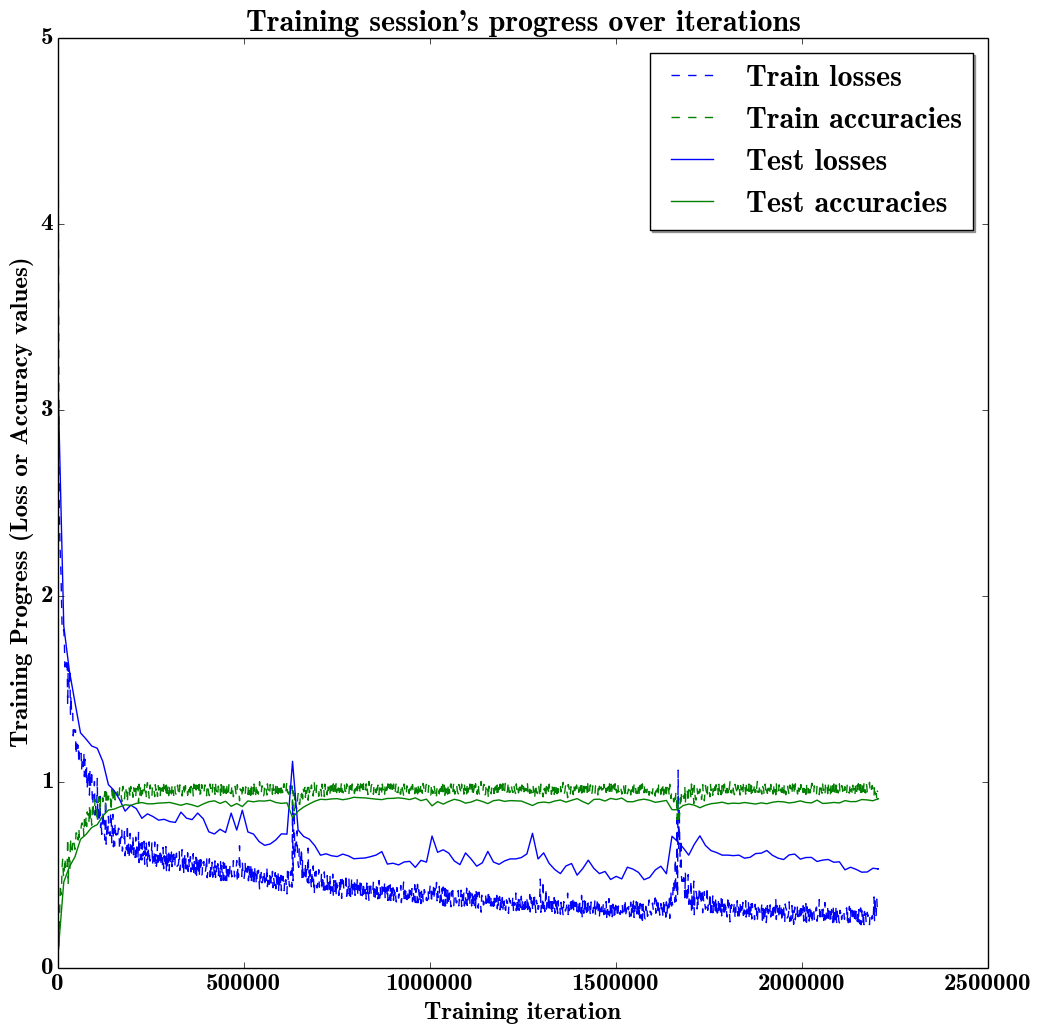

In [9]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1] + [training_iters])
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

## And finally, the multi-class confusion matrix and metrics!

Testing Accuracy: 90.7702744007%

Precision: 90.8521998563%
Recall: 90.7702748558%
f1_score: 90.7685497939%

Confusion Matrix:
[[450   2  15  12  17   0]
 [ 30 427  14   0   0   0]
 [  5   0 415   0   0   0]
 [  0  22   3 402  64   0]
 [  1   6   0  54 471   0]
 [  0  27   0   0   0 510]]

Confusion matrix (normalised to % of total test data):
[[ 15.2697649    0.06786563   0.5089922    0.40719375   0.57685781   0.        ]
 [  1.01798439  14.48931122   0.47505939   0.           0.           0.        ]
 [  0.16966406   0.          14.08211708   0.           0.           0.        ]
 [  0.           0.74652189   0.10179844  13.64099121   2.1717       0.        ]
 [  0.03393281   0.20359688   0.           1.83237195  15.98235512   0.        ]
 [  0.           0.91618598   0.           0.           0.          17.30573463]]
Note: training and testing data is not equally distributed amongst classes, so it is normal that more than a 6th of the data is correctly classifier in the last catego

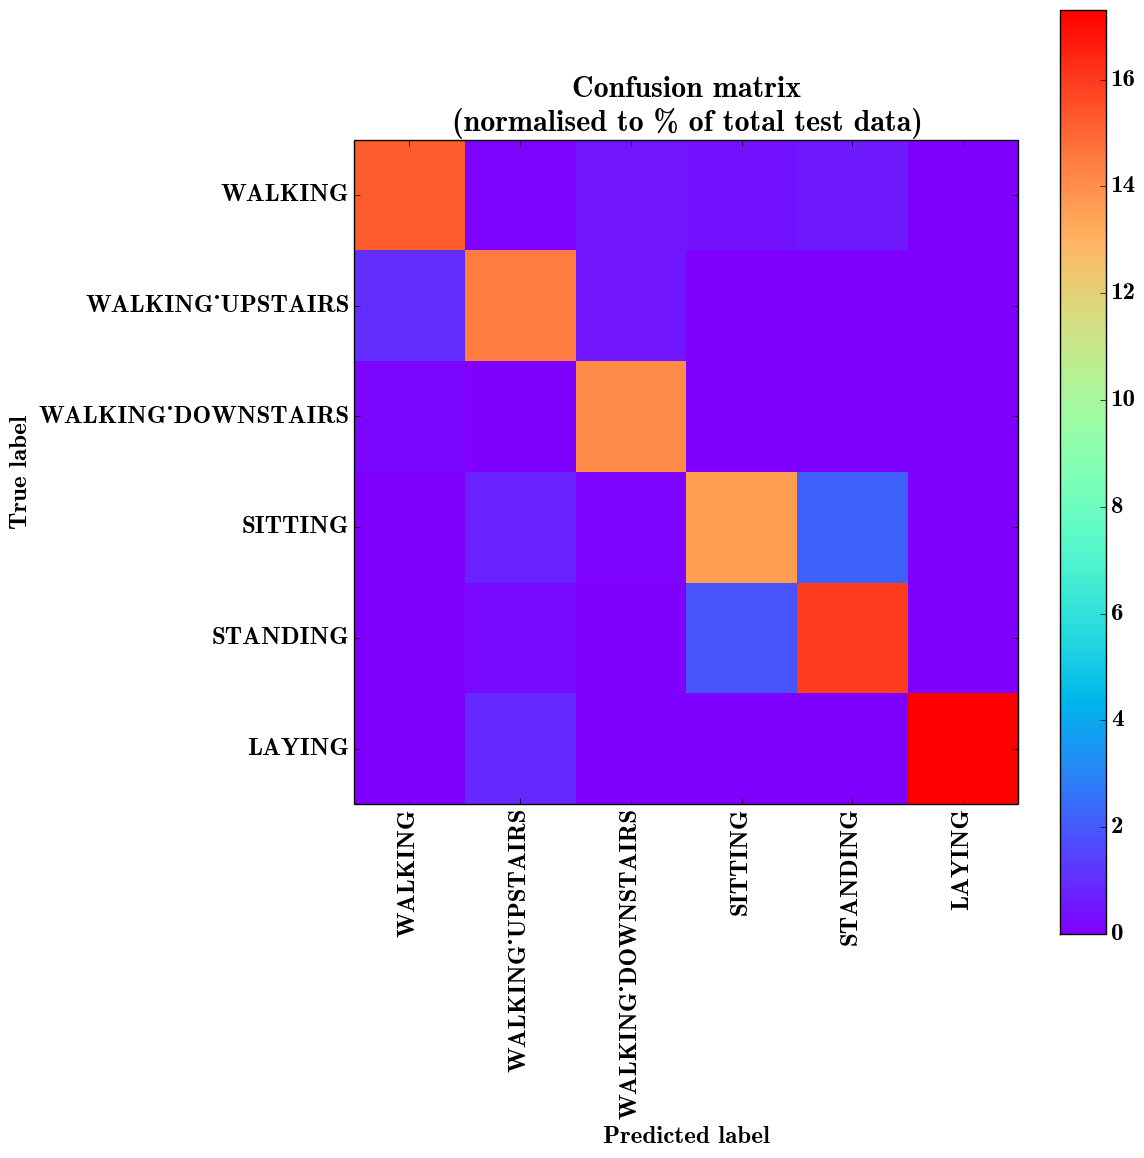

In [10]:
# Results

predictions = one_hot_predictions.argmax(1)

print "Testing Accuracy: {}%".format(100*accuracy)

print ""
print "Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted"))
print "Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted"))
print "f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted"))

print ""
print "Confusion Matrix:"
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print confusion_matrix
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print ""
print "Confusion matrix (normalised to % of total test data):"
print normalised_confusion_matrix
print ("Note: training and testing data is not equally distributed amongst classes, "
       "so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [11]:
sess.close()

## Conclusion

Outstandingly, **the accuracy is of 90.77%**! 

This means that the neural networks is almost always able to correctly identify the movement type! Remember, the phone is attached on the waist and each series to classify has just a 128 sample window of two internal sensors (a.k.a. 2.56 seconds at 50 FPS), so those predictions are extremely accurate.

I specially did not expect such good results for guessing between "WALKING" "WALKING_UPSTAIRS" and "WALKING_DOWNSTAIRS" as a cellphone. Thought, it is still possible to see a little cluster on the matrix between those 3 classes. This is great.

It is also possible to see that it was hard to do the difference between "SITTING" and "STANDING". Those are seemingly almost the same thing from the point of view of a device placed on the belly, according to how the dataset was gathered. 

I also tried my code without the gyroscope, using only the two 3D features of the accelerometer, and got an accuracy of 86.90%.


## References

The [dataset](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) can be found on the UCI Machine Learning Repository. 

> Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

If you want to cite my work, you can point to the URL of the GitHub repository: 
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

## Connect with me

- https://ca.linkedin.com/in/chevalierg 
- https://twitter.com/guillaume_che
- https://github.com/guillaume-chevalier/

In [12]:
# Let's convert this notebook to a README as the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] Converting notebook LSTM.ipynb to markdown
[NbConvertApp] Support files will be in LSTM_files/
[NbConvertApp] Making directory LSTM_files
[NbConvertApp] Making directory LSTM_files
[NbConvertApp] Writing 41999 bytes to LSTM.md
